In [24]:
# pip install seaborn==0.11.0 --user

In [38]:
import numpy as np
import pandas as pd

import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import seaborn as sns
import matplotlib.pyplot as plt

1. Загрузить данные: 'insurance.csv'. Вывести и провести предобработку.
Вывести список уникальных регионов.

In [7]:
df = pd.read_csv("insurance.csv")
print(df.shape)
df.head(3)

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [8]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
df.duplicated().any()

True

In [10]:
df = df.drop_duplicates()
df.shape

(1337, 7)

In [11]:
df.region.unique().tolist()

['southwest', 'southeast', 'northwest', 'northeast']

2. Выполнить однофакторный ANOVA тест, чтобы проверить влияние
региона на индекс массы тела (BMI), используя первый способ, через
библиотеку Scipy.

In [12]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

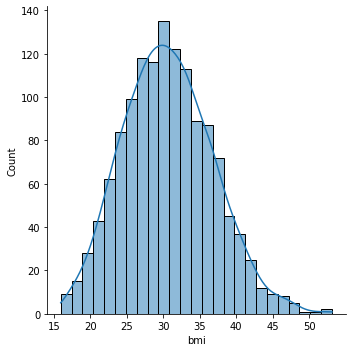

In [13]:
# Проверяем распределение на нормальность графически
sns.displot(x='bmi', kde=True, data=df);

In [14]:
# и практически с помощью вычисленной статистики теста Колмогорова-Смирнова
bmi_ks_test = st.kstest(st.zscore(df.bmi), 'norm')
print('p-значение для bmi:', round(bmi_ks_test[1], 3))

p-значение для bmi: 0.304


**Гипотезы для теста Колмогорова-Смирнова.**

Нулевая гипотеза: выборка имеет нормальное распределение (p-value > 0.05).

Альтернативная гипотеза: выборка не имеет нормального распределения (p-value < 0.05).

p-значение больше 0.05, поэтому гипотеза о нормальности распределения принимается. Теперь проверим равенство дисперсий в группах по регионам с помощью теста Левена.

In [19]:
regions = ['southwest', 'southeast', 'northwest', 'northeast']
groups = df.groupby('region')['bmi'].groups

southwest = df.bmi[groups['southwest']]
southeast = df.bmi[groups['southeast']]
northwest = df.bmi[groups['northwest']]
northeast = df.bmi[groups['northeast']]

In [23]:
st.levene(southwest, southeast, northwest, northeast, center='median')

LeveneResult(statistic=6.112705911854986, pvalue=0.00039621339987129067)

**Гипотезы для теста Левена.**

Нулевая гипотеза: дисперсия между группами одинакова (p-value > 0.05).

Альтернативная гипотеза: дисперсия между разными группами не одинакова (по крайней мере, для одной пары дисперсия не равна другим) (p-value < 0.05).

p-значение намного меньше 0.05, что позволяет отвергнуть нулевую гипотезу. То есть у нас есть основания полагать, что между группами регионов есть различия в собранных измерениях индекса массы тела человека. А значит, равенство дисперсий не соблюдается. Это нужно учитывать при проведении однофакторного дисперсионного анализа.

In [25]:
st.f_oneway(southwest, southeast, northwest, northeast)

F_onewayResult(statistic=39.48593864487439, pvalue=1.9087293927440606e-24)

**Гипотезы однофакторного дисперсионного анализа**

Нулевая гипотеза: в генеральной совокупности нет значимых различий
между средними, все средние трёх групп равны друг другу (p-value > 0.05).

Альтернативная гипотеза: хотя бы пара средних значимо различается между собой (p-value < 0.05).

p-значение значительно меньше 0.05. Мы так же приходим к выводу, что есть существенные различия между группами.

3. Выполнить однофакторный ANOVA тест, чтобы проверить влияние
региона на индекс массы тела (BMI), используя второй способ, с помощью
функции anova_lm() из библиотеки statsmodels.

In [28]:
model = ols('bmi ~ region', data=df).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

                sum_sq      df          F        PR(>F)
region     4057.813904     3.0  39.485939  1.908729e-24
Residual  45662.381091  1333.0        NaN           NaN


Получили то же самое p-значение.

4. С помощью t-критерия Стьюдента перебрать все пары. Определить
поправку Бонферрони. Сделать выводы.

Было бы интересно узнать, в каких именно группах
есть влияние. Для этого можно
использовать t-критерий Стьюдента для всех пар регионов, но такой метод при
большом разнообразии групп может дать слишком большую ошибку.
Метод Бонферрони является одним из наиболее простых и известных
способов контроля над групповой вероятностью ошибки.

In [32]:
region_pairs = []

for region_1 in range(4):
    for region_2 in range(region_1 + 1, 4):
        region_pairs.append((regions[region_1], regions[region_2]))
        
region_pairs

[('southwest', 'southeast'),
 ('southwest', 'northwest'),
 ('southwest', 'northeast'),
 ('southeast', 'northwest'),
 ('southeast', 'northeast'),
 ('northwest', 'northeast')]

In [33]:
for region_1, region_2 in region_pairs:
    print(region_1, region_2)
    print(st.ttest_ind(df.bmi[groups[region_1]], df.bmi[groups[region_2]]))

southwest southeast
Ttest_indResult(statistic=-5.908373821545118, pvalue=5.4374009639680636e-09)
southwest northwest
Ttest_indResult(statistic=3.289593460501664, pvalue=0.0010577505931067947)
southwest northeast
Ttest_indResult(statistic=3.1169000930045923, pvalue=0.0019086161671573072)
southeast northwest
Ttest_indResult(statistic=9.252137489219615, pvalue=2.7504255547794223e-19)
southeast northeast
Ttest_indResult(statistic=8.790905562598699, pvalue=1.186014937424813e-17)
northwest northeast
Ttest_indResult(statistic=0.05038637314068614, pvalue=0.9598300701853016)


Сравним p-значения с alpha после поправки Бонферрони:

In [37]:
print(f'alpha: {round(0.05/6, 4)}')

alpha: 0.0083


Значение alpha превышает только пара northwest-northeast, следовательно, замеры в выборках по этим двум регионам отличаются от других регионов. Об этом же свидетельствует наиболее приближенные p-значения у пар southwest-northeast, southwest-northwest.

5. Выполнить пост-хок тесты Тьюки и построить график.

После проведения дисперсионного анализа получаем данные о том,
значимо ли влияние изучаемого фактора на данные: различаются ли между
группами средние значения зависимой переменной. Однако результаты
анализа не дают ответа на вопрос: благодаря каким различиям это влияние
оказалось значимым?
Для решения данной задачи предназначены пост-хок тесты.

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,0.022,0.9,-1.1609,1.2048,False
northeast,southeast,4.1825,0.001,3.0326,5.3324,True
northeast,southwest,1.4231,0.0107,0.2412,2.605,True
northwest,southeast,4.1605,0.001,3.0106,5.3104,True
northwest,southwest,1.4011,0.0125,0.2192,2.5831,True
southeast,southwest,-2.7594,0.001,-3.9083,-1.6104,True


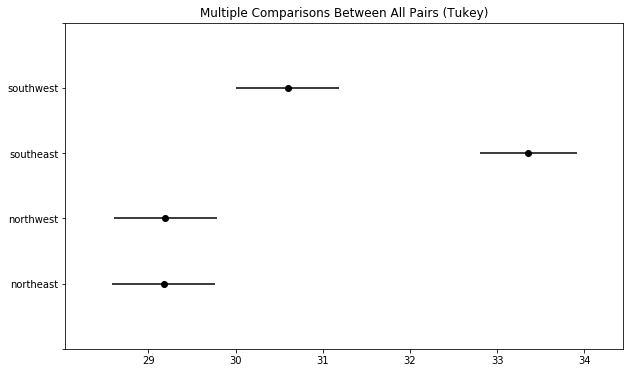

In [40]:
tukey = pairwise_tukeyhsd(endog=df.bmi, groups=df.region, alpha=0.05)
tukey.plot_simultaneous()
# plt.vlines()
tukey.summary()

6. Выполнить двухфакторный ANOVA тест, чтобы проверить влияние
региона и пола на индекс массы тела (BMI), используя функцию anova_lm()
из библиотеки statsmodels.

In [42]:
model = ols('bmi ~ region + sex + region:sex', data=df).fit()
print(sm.stats.anova_lm(model, typ=2))

                  sum_sq      df          F        PR(>F)
region       4036.141807     3.0  39.381780  2.215903e-24
sex            85.359929     1.0   2.498643  1.141824e-01
region:sex    175.040197     3.0   1.707917  1.635099e-01
Residual    45401.980965  1329.0        NaN           NaN


Поскольку p-значения для region гораздо меньше 0.05, это означает, что
данный фактор оказывают статистически значимое влияние на индекс массы тела.

р-значение для двух других факторов превышает 0.05. То есть пол и пол+регион не оказывает статистически значимое влияние на индекс массы тела.

7. Выполнить пост-хок тесты Тьюки и построить график.

group1,group2,meandiff,p-adj,lower,upper,reject
female/northeast,female/northwest,-0.0464,0.9,-2.0149,1.9222,False
female/northeast,female/southeast,3.3469,0.001,1.4093,5.2846,True
female/northeast,female/southwest,0.7362,0.9,-1.2384,2.7107,False
female/northeast,male/northeast,-0.2998,0.9,-2.2713,1.6717,False
female/northeast,male/northwest,-0.2133,0.9,-2.194,1.7673,False
female/northeast,male/southeast,4.6657,0.001,2.7627,6.5686,True
female/northeast,male/southwest,1.8051,0.101,-0.1664,3.7767,False
female/northwest,female/southeast,3.3933,0.001,1.4649,5.3217,True
female/northwest,female/southwest,0.7825,0.9,-1.1829,2.748,False
female/northwest,male/northeast,-0.2534,0.9,-2.2158,1.709,False


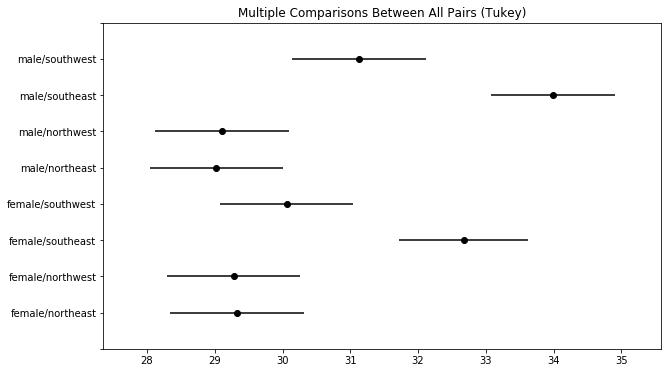

In [43]:
df['combination'] = df.sex + '/' + df.region
tukey = pairwise_tukeyhsd(endog=df.bmi, groups=df.combination, alpha=0.05)
tukey.plot_simultaneous()
# plt.vlines()
tukey.summary()